In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
%load_ext autoreload

%autoreload 1

In [ ]:
import numpy as np
import pandas as pd

import pickle

from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt

# Load data

In [ ]:
data_root = Path.home() / "data" / "tmp"
reuters_dir = data_root / "reuters21578"
reuters_corpus_path = reuters_dir / "corpus.pkl"
reuters = pickle.load(open(str(reuters_corpus_path), "rb"))
top_ten_ids, top_ten_names = reuters.top_n(n=10)

cache_dir = reuters_dir / "cache"

# Build dataframe

In [ ]:
df, top_ten_ids, train_labels, test_labels = reuters.build_dataframe()

In [ ]:
df.head()

,modapte,category,label,date,title,dateline,body,newid,wd_name
0,train,interest,0,1987-03-11 18:14:49,U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK,"CHICAGO, March 11 -",U.S. economic data this week could be\nthe key...,4005,Wednesday
1,train,earn,3,1987-03-11 18:36:05,BANK OF BRITISH COLUMBIA 1ST QTR JAN 31 NET,"VANCOUVER, British Columbia, March 11 -\n",Oper shr loss two cts vs profit three cts\n ...,4012,Wednesday
2,train,earn,3,1987-03-11 18:38:02,RESTAURANT ASSOCIATES INC <RA> 4TH QTR JAN 3,"NEW YORK, March 11 -\n",Shr 25 cts vs 36 cts\n Net 1.4 mln vs 1.4 m...,4014,Wednesday
3,train,earn,3,1987-03-11 18:41:59,MICHIGAN GENERAL CORP <MGL> 4TH QTR,"SADDLE BROOK, N.J., March 11 -\n",Shr loss 1.02 dlrs vs 1.01 dlr\n Net loss 1...,4015,Wednesday
4,train,crude,4,1987-03-11 18:45:36,"USX <X> PROVED OIL, GAS RESERVES FALL IN 1986","NEW YORK, March 11 -",USX Corp said proved reserves of oil\nand natu...,4016,Wednesday


# Build feature extraction pipeline

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC

## Transformer

In [ ]:
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras.preprocessing import sequence

In [ ]:
from ds_tutorial.transformers import TextFromColumns, TextStats, TextFromColumns2

In [ ]:
class SequentialTextFromColumns(BaseEstimator, TransformerMixin):
    """Extract the text from a list of columns in a single pass.

    Takes a pandas dataframe and produces a series of sequence data
    from joined columns defined in `text_cols`.
    """
    text_cols = ["title", "body"]
    
    def __init__(self, text_cols=["title", "body"], max_sequence_length=1323, top_k=None):
        self.text_cols = text_cols
        self.max_sequence_length = max_sequence_length
        self.tokenizer = text.Tokenizer(num_words=top_k)
        
    def text_from_df(self, df):
        return TextFromColumns2().transform(df)
        
    def fit(self, df_train, y_train):
        train_text = self.text_from_df(df_train)
        self.tokenizer.fit_on_texts(train_text)
        return self

    def transform(self, df):
        text = TextFromColumns2().transform(df)        
        X = self.tokenizer.texts_to_sequences(text)
        
        max_length = len(max(X, key=len))
        if max_length > self.max_sequence_length:
            max_length = self.max_sequence_length

        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        X = sequence.pad_sequences(X, maxlen=max_length)
        return X

## Model

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    # op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    op_activation = "softmax"
    op_units = num_classes
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [ ]:
df_train = df.query("modapte == 'train'")
df_test = df.query("modapte == 'test'")
y_train = df_train.label.values
y_test = df_test.label.values

In [ ]:
top_k = 2000000
stfc = SequentialTextFromColumns(top_k=top_k)
stfc.fit(df_train, y_train)
num_features = min(len(stfc.tokenizer.word_index) + 1, top_k)

# Sequential model

In [ ]:
from tensorflow.python.keras.optimizers import Adam

model = sepcnn_model(
    blocks=2,
    filters=64,
    kernel_size=3,
    embedding_dim=200,
    dropout_rate=0.2,
    pool_size=3,
    input_shape=(stfc.max_sequence_length,),
    num_classes=75,
    num_features=num_features
)

optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
pipeline = Pipeline(steps=[
    ("combined_text_sequential", Pipeline([
        ("sequences", SequentialTextFromColumns(top_k=20000)),
    ])),
    # ("clf", model)
])

In [ ]:
X_train = pipeline.fit_transform(df_train, y_train)
X_test = pipeline.transform(df_test)

In [ ]:
import tensorflow as tf
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

In [ ]:
history = model.fit(
    X_train,
    y_train,
    #epochs=500,
    epochs=70,
    validation_data=(X_test, y_test),
    #callbacks=callbacks,
    batch_size=128
)

Train on 7770 samples, validate on 3019 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/70
7770/7770 [==============================] - 63s 8ms/sample - loss: 3.9824 - acc: 0.3206 - val_loss: 3.0051 - val_acc: 0.3601
Epoch 2/70
2560/7770 [========>.....................] - ETA: 39s - loss: 2.6656 - acc: 0.3535

In [ ]:
import json

models_dir = data_root / "models" 
models_dir.mkdir(exist_ok=True)
model.save(str(models_dir / "reuters_sequential.h5"))

history_path = models_dir / "reuters_sequential.json"
with open(str(history_path), "w") as f:
    json.dump(history.history, f)

AttributeError: 'dict' object has no attribute 'history'

In [ ]:
history = json.load(open(str(history_path)))

In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.962     0.975     0.968      1087
        acq      0.955     0.921     0.938       710
   money-fx      0.617     0.766     0.683       145
      grain      0.267     0.190     0.222        42
      crude      0.740     0.799     0.768       164
      trade      0.617     0.725     0.667       109
   interest      0.673     0.581     0.624       117
       ship      0.449     0.310     0.367        71
      wheat      0.630     0.618     0.624        55
       corn      0.418     0.511     0.460        45

avg / total      0.855     0.861     0.856      2545



In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.988     0.975     0.981      1087
        acq      0.943     0.952     0.947       710
   money-fx      0.632     0.793     0.703       145
      grain      0.400     0.286     0.333        42
      crude      0.778     0.835     0.806       164
      trade      0.599     0.780     0.677       109
   interest      0.679     0.632     0.655       117
       ship      0.582     0.451     0.508        71
      wheat      0.680     0.618     0.648        55
       corn      0.456     0.689     0.549        45

avg / total      0.874     0.886     0.878      2545



In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.987     0.974     0.981      1087
        acq      0.947     0.951     0.949       710
   money-fx      0.592     0.800     0.680       145
      grain      0.200     0.381     0.262        42
      crude      0.854     0.640     0.732       164
      trade      0.622     0.514     0.563       109
   interest      0.664     0.709     0.686       117
       ship      0.481     0.535     0.507        71
      wheat      0.537     0.655     0.590        55
       corn      0.435     0.667     0.526        45

avg / total      0.868     0.870     0.866      2545



In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred, target_names=top_ten_names, labels=top_ten_ids, digits=3))

             precision    recall  f1-score   support

       earn      0.971     0.977     0.974      1087
        acq      0.911     0.962     0.936       710
   money-fx      0.606     0.731     0.662       145
      grain      0.319     0.357     0.337        42
      crude      0.799     0.799     0.799       164
      trade      0.676     0.688     0.682       109
   interest      0.686     0.692     0.689       117
       ship      0.351     0.479     0.405        71
      wheat      0.744     0.582     0.653        55
       corn      0.543     0.556     0.549        45

avg / total      0.856     0.882     0.868      2545



# Plot training vs test accuracy

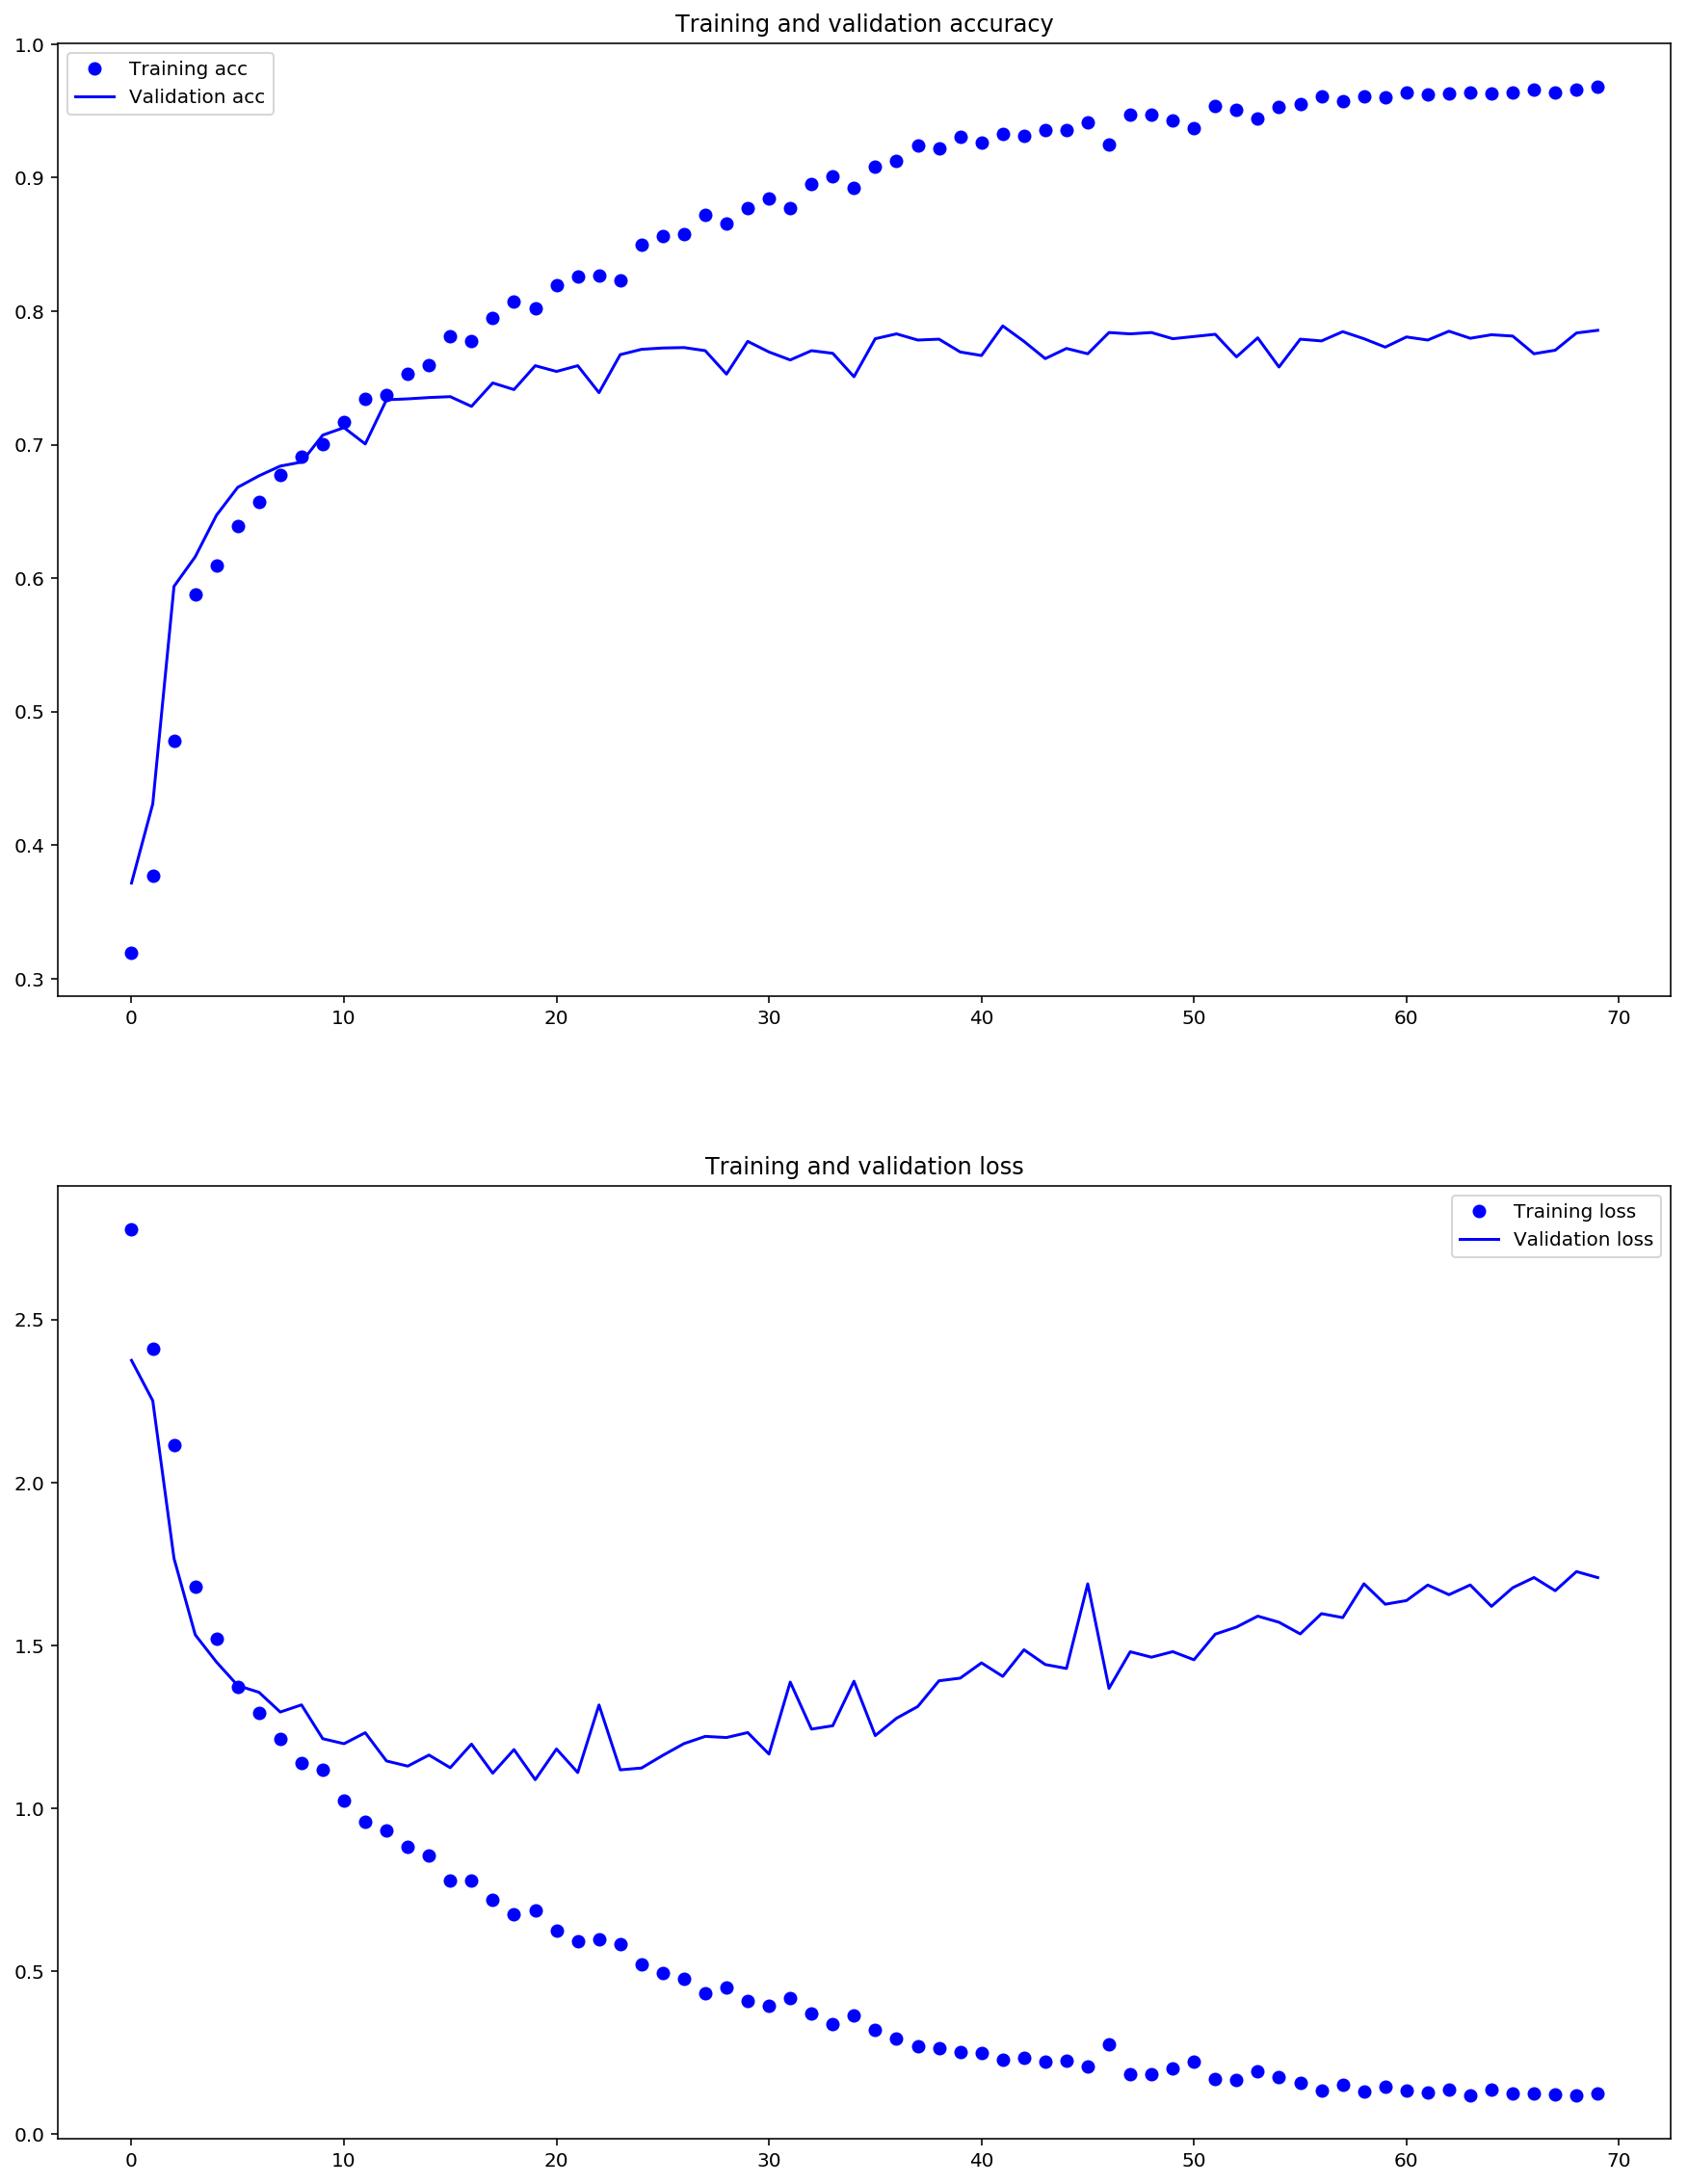

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15, 20))

plt.subplot(211)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()